In [ ]:
from scipy import sparse
import pickle
import pandas as pd
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer
import joblib
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB

In [47]:
# load the data
X_train = sparse.load_npz(r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\X_train.npz')
X_cv = sparse.load_npz(r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\X_cv.npz')
X_test = sparse.load_npz(r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\X_test.npz')

In [44]:
Y_train = pd.read_pickle(r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\Y_train.pickle')
Y_cv = pd.read_pickle(r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\Y_cv.pickle')

In [45]:
with open(r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\final_column_list.text', 'rb') as fp:
    final_column_list = pickle.load(fp)

In [48]:
print("Final dataset :")
print("Train dataset:", X_train.shape)
print("CV dataset:", X_cv.shape)
print("Test dataset:", X_test.shape)
print("="*100)
print("Total Number of columns:", len(final_column_list))
print("Target train variable count:", Y_train.shape)
print("Target cv variable count:", Y_cv.shape)

Final dataset :
Train dataset: (59052, 624)
CV dataset: (14763, 624)
Test dataset: (61668, 624)
Total Number of columns: 617
Target train variable count: (59052,)
Target cv variable count: (14763,)


In [38]:
X_test = pd.DataFrame(X_test)
X_test.head()

,0
0,"(0, 0)\t35.0\n (0, 2)\t2014.0\n (0, 3)\t7...."
1,"(0, 0)\t37.61667670078266\n (0, 2)\t2014.0\..."
2,"(0, 0)\t37.61667670078266\n (0, 2)\t2014.0\..."
3,"(0, 0)\t37.61667670078266\n (0, 2)\t2014.0\..."
4,"(0, 0)\t37.61667670078266\n (0, 2)\t2014.0\..."


In [59]:
le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_train

array([10,  7,  7, ...,  7, 10, 10])

In [103]:
Y_cv = le.fit_transform(Y_cv)
Y_cv

array([ 7,  7,  7, ..., 10, 11, 10])

In [120]:
def dcg_score(y_true, y_score, k=5):
    
    """Discounted cumulative gain (DCG) at rank K.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.

    Returns
    -------
    score : float
    """
    
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):
    
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    
    lb = LabelBinarizer()
    lb.fit(range(predictions.shape[1] + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)


# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

In [88]:
# save test id from X_test file 

test_df = pd.read_csv(r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\test_user_merged.csv')
test_id = test_df['id'].values
print(test_id)


['5uwns89zht' 'jtl0dijy2j' 'xx0ulgorjt' ... 'fa6260ziny' '87k0fy4ugm'
 '9uqfg8txu3']


In [49]:
# Logistic regression

params = {'C': [0.0001, 0.001, 0.01, 0.1]}
lr = linear_model.LogisticRegression(multi_class = 'multinomial')
clf_lr = RandomizedSearchCV(lr, params, verbose = 1, n_iter= 3, n_jobs=1, scoring = ndcg_scorer)

In [50]:
clf_lr.fit(X_train, Y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\Wenxia\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Wenxia\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Wenxia\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\Wenxia\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", li

RandomizedSearchCV(estimator=LogisticRegression(multi_class='multinomial'),
                   n_iter=3, n_jobs=1,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1]},
                   scoring=make_scorer(ndcg_score, needs_proba=True, k=5),
                   verbose=1)

In [54]:
clf_lr.best_estimator_

LogisticRegression(C=0.001, multi_class='multinomial')

In [121]:
pred_Y_train = clf_lr.predict_proba(X_train)

In [122]:
train_ndcg_lr = ndcg_score(Y_train, pred_Y_train, k = 5)
train_ndcg_lr

0.8161697870003184

In [123]:
pred_Y_cv = clf_lr.predict_proba(X_cv)

In [124]:
pred_Y_test = clf_lr.predict_proba(X_test)

In [125]:
print(pred_Y_test.shape)

(61668, 12)


In [126]:
ids = []
countries = []

for i in range(len(test_id)-1):
    idx = test_id[i]
    ids += [idx]*5
    countries += le.inverse_transform(np.argsort(pred_Y_test[i])[::-1][:5]).tolist()

sub = pd.DataFrame({"id": ids, "country": countries})
sub.to_csv(r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\lr_submission.csv', index=False)

In [129]:
# save the LR model
joblib.dump(clf_lr, r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\clf_lr')

PicklingError: Can't pickle <function ndcg_score at 0x0000023B84EBB430>: it's not the same object as __main__.ndcg_score

In [86]:
# random forest
params = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [10, 20, 30, 50],
    'min_samples_split': [2 ,5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}
rf = RandomForestClassifier()

clf_rf = RandomizedSearchCV(rf, params, verbose=2, n_jobs=-1, scoring=ndcg_score, return_train_score=True, cv=5)


In [94]:
params = {
    'n_estimators': [10, 50],  # Reduced number of trees
    'max_depth': [5, 10],      # Shallower trees
    'min_samples_split': [5, 10],  # Fewer splits
    'min_samples_leaf': [2, 5]  # Larger minimum leaf size
}

rf = RandomForestClassifier()

clf_rf = RandomizedSearchCV(rf, params, verbose=10, n_jobs=-1, scoring=ndcg_scorer, return_train_score=True, cv=5)

In [96]:
clf_rf.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10],
                                        'min_samples_leaf': [2, 5],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [10, 50]},
                   return_train_score=True,
                   scoring=make_scorer(ndcg_score, needs_proba=True, k=5),
                   verbose=10)

In [211]:
clf_rf.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=50)

In [97]:
pred_Y_train = clf_rf.predict_proba(X_train)

In [102]:
train_ndcg_rf = ndcg_score(Y_train, pred_Y_train, k=5)
train_ndcg_rf

0.8551310487719246

In [99]:
pred_Y_cv = clf_rf.predict_proba(X_cv)

In [104]:
cv_ndcg_rf = ndcg_score(Y_cv, pred_Y_cv, k=5)
cv_ndcg_rf

0.8255319658648265

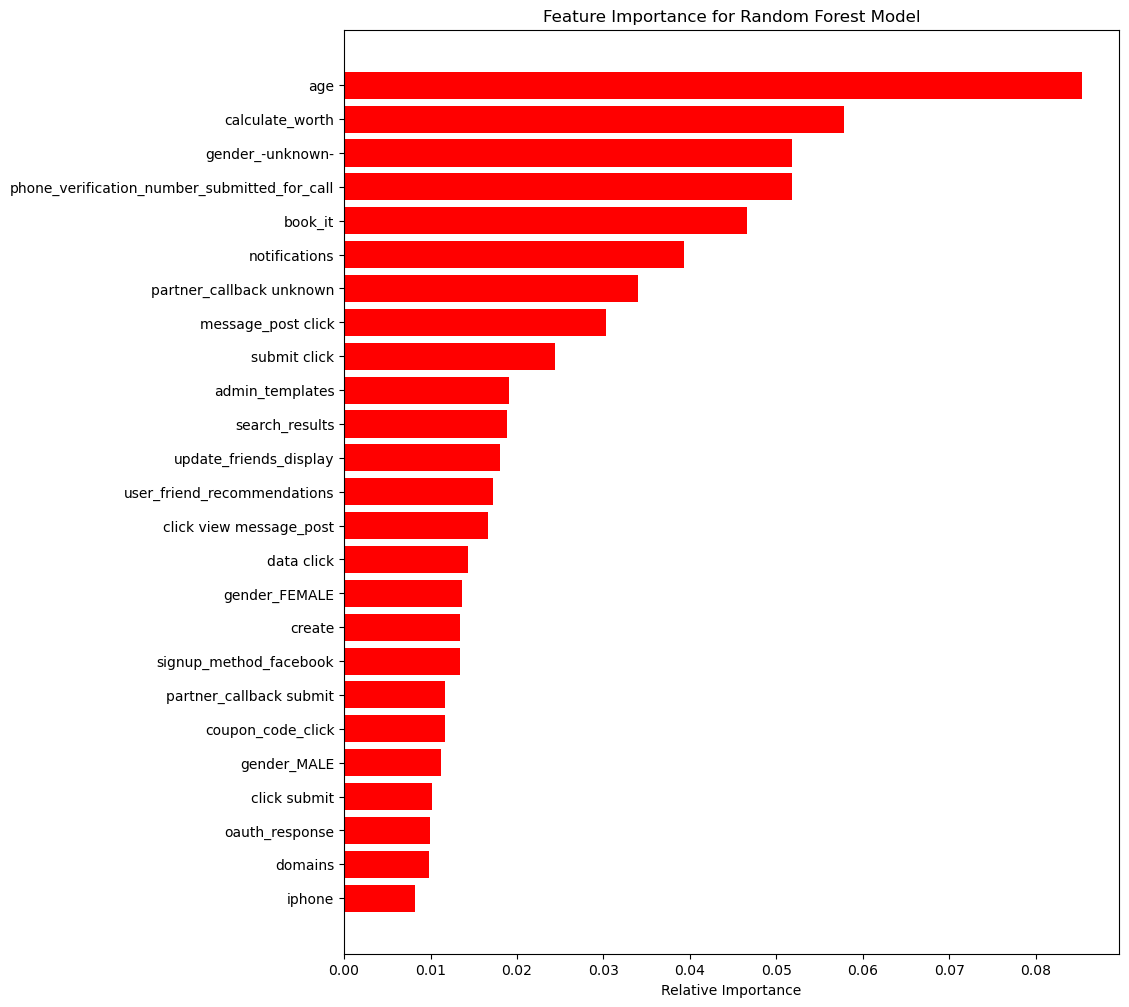

In [105]:
# Feature importance for random forest model
features = final_column_list
importances = clf_rf.best_estimator_.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importance for Random Forest Model')
plt.barh(range(len(indices)), importances[indices], color = 'r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [106]:
results_rf = clf_rf.cv_results_
x_axis = np.array(results_rf['param_n_estimators'].data, dtype=float)
y_axis = np.array(results_rf['param_max_depth'].data, dtype=float)

In [108]:
pvt_test = pd.DataFrame(results_rf)
pvt_test.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,15.604092,0.684975,1.289317,0.062709,50,10,5,10,"{'n_estimators': 50, 'min_samples_split': 10, ...",0.842716,...,0.843452,0.000412,3,0.856393,0.856878,0.856022,0.857296,0.857126,0.856743,0.000472
1,1.183100,0.067229,1.070210,0.059942,10,10,5,5,"{'n_estimators': 10, 'min_samples_split': 10, ...",0.842682,...,0.842168,0.000513,10,0.844006,0.843086,0.842751,0.843733,0.843788,0.843473,0.000474
2,5.357082,0.385033,1.188657,0.069239,50,10,2,5,"{'n_estimators': 50, 'min_samples_split': 10, ...",0.842262,...,0.842601,0.000451,6,0.843861,0.843302,0.843278,0.843763,0.843948,0.843630,0.000284
3,16.233856,0.676247,1.400213,0.089522,50,5,5,10,"{'n_estimators': 50, 'min_samples_split': 5, '...",0.844394,...,0.843960,0.000811,1,0.857059,0.856037,0.856947,0.856758,0.857361,0.856833,0.000443
4,1.080351,0.054163,1.101945,0.018298,10,5,2,5,"{'n_estimators': 10, 'min_samples_split': 5, '...",0.842325,...,0.842539,0.000704,7,0.843726,0.843509,0.843573,0.843838,0.843760,0.843681,0.000122


Text(0.5, 1.0, 'Train NDCG Heatmap')

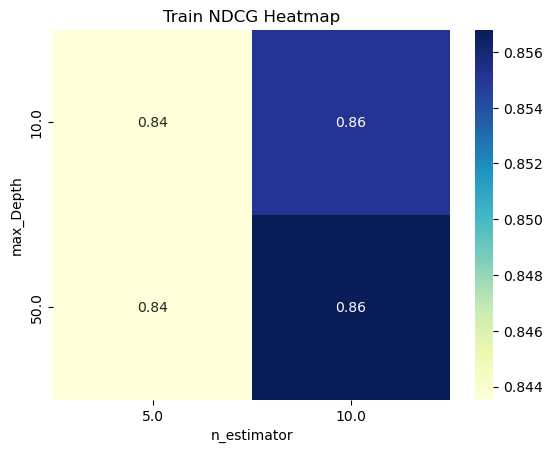

In [109]:
# heat map to show train and cv ndcg scorefor different values of 'max_depth' and 'n_estimators': 
pvt_test = pd.pivot_table(pd.DataFrame(results_rf), values='mean_train_score', index=x_axis, columns=y_axis)
sns.heatmap(pvt_test, annot=True, cmap='YlGnBu')
plt.xlabel('n_estimator') 
plt.ylabel('max_Depth')
plt.title('Train NDCG Heatmap')

Text(0.5, 1.0, 'Test NDCG Heatmap')

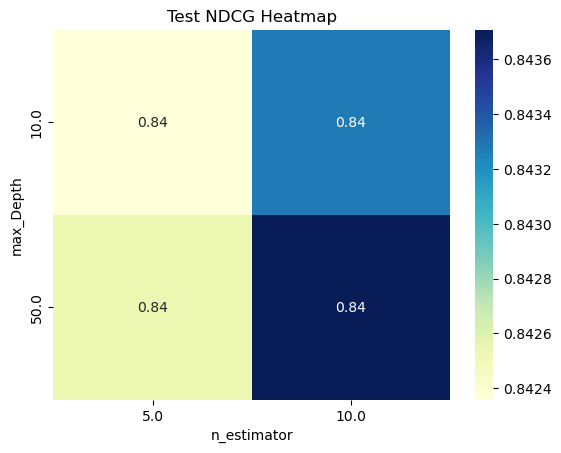

In [110]:
pvt_test = pd.pivot_table(pd.DataFrame(results_rf), values='mean_test_score', index=x_axis, columns=y_axis)
sns.heatmap(pvt_test, annot=True, cmap='YlGnBu')
plt.xlabel('n_estimator') 
plt.ylabel('max_Depth')
plt.title('Test NDCG Heatmap')

In [111]:
pred_Y_test = clf_rf.predict_proba(X_test)
print(pred_Y_test.shape)
print(pred_Y_test[1])

(61668, 12)
[0.00126719 0.00563885 0.00161831 0.01657516 0.02032628 0.00743744
 0.0100672  0.65117679 0.0026934  0.00110056 0.22785849 0.05424034]


In [ ]:
ids = []
countries = []

for i in range(len(test_id)-1): 
    idx = test_id[i]
    ids += [idx]*5
    countries += le.inverse_transform(np.argsort(pred_Y_test)[i][::-1][:5]).tolist()

In [112]:
sub = pd.DataFrame({"id": ids, "country": countries})
print(sub.head())

           id country
0  5uwns89zht     NDF
1  5uwns89zht      US
2  5uwns89zht   other
3  5uwns89zht      AU
4  5uwns89zht      GB


In [130]:
sub.to_csv(r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\rf_submission.csv', index=False)

joblib.dump(clf_rf, r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\clf_rf')

PicklingError: Can't pickle <function ndcg_score at 0x0000023B84EBB430>: it's not the same object as __main__.ndcg_score

In [133]:
param_grid = {
    'max_depth': [5, 10, 15],
    'n_estimators': [100, 200, 300]
}

xgb = xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss')
clf_xgb = RandomizedSearchCV(xgb, param_grid, n_jobs=-1, verbose=2, scoring=ndcg_scorer, random_state=42)

In [ ]:
clf_xgb.fit(X_train, Y_train)

c:\Users\Wenxia\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [ ]:
clf_xgb.best_params_

In [ ]:
# Feature importance for random forest model
features = final_column_list
importances = clf_xgb.best_estimator_.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importance for XGboost Model')
plt.barh(range(len(indices)), importances[indices], color = 'r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
results_xgb = clf_xgb.cv_results_
x_axis = np.array(results_xgb['param_n_estimators'].data, dtype=float)
y_axis = np.array(results_xgb['param_max_depth'].data, dtype=float)

In [ ]:
pvt_test = pd.pivot_table(pd.DataFrame(results_xgb), values='mean_train_score', index=x_axis, columns=y_axis)
sns.heatmap(pvt_test, annot=True, cmap='YlGnBu')
plt.xlabel('n_estimator') 
plt.ylabel('max_Depth')
plt.title('Train NDCG Heatmap')

In [ ]:
pvt_test = pd.pivot_table(pd.DataFrame(results_xgb), values='mean_test_score', index=x_axis, columns=y_axis)
sns.heatmap(pvt_test, annot=True, cmap='YlGnBu')
plt.xlabel('n_estimator') 
plt.ylabel('max_Depth')
plt.title('CV NDCG Heatmap')

In [ ]:
pred_Y_train = clf_xgb.predict_proba(X_train)

(61668, 12)


In [ ]:
train_ndcg_xgb = ndcg_score(Y_train, pred_Y_train)
train_ndcg_xgb

In [ ]:
pred_Y_cv = clf_xgb.predict_proba(X_cv)
cv_ndcg_xgb = ndcg_score(Y_cv, pred_Y_cv)
cv_ndcg_xgb

In [ ]:
pred_Y_test = clf_xgb.predict_proba(X_test)

(61668, 12)


In [ ]:
ids = []
countries = []

for i in range(len(test_id)-1): 
    idx = test_id[i]
    ids += [idx]*5
    countries += le.inverse_transform(np.argsort(pred_Y_test)[i][::-1][:5]).tolist()

In [ ]:
sub = pd.DataFrame({"id": ids, "country": countries})
print(sub.head())

In [ ]:
sub.to_csv(r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\xgb_submission.csv', index=False)

joblib.dump(clf_xgb, r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\clf_xgb')

In [ ]:
params = {'alpha': [0.00001,0.0001,0.001,0.01,0.1,1,10,100]}
clf_nb = MultinomialNB()
clf_nb = RandomizedSearchCV(nb, params, verbose=2, n_iter=3, n_jobs=-1, scoring=ndcg_scorer)